In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

/home/csslab/miniconda3/envs/learning/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

In [ ]:

prompt = ["stopo sign"]

# seed giving better results: 4
# interesting fact: height and width also influences the result

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 6  # Number of denoising steps
guidance_scale = 9.5 # Scale for classifier-free guidance
seed = 4
generator = torch.manual_seed(seed)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# text_embeddings.shape, uncond_embeddings.shape

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.00it/s]


In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

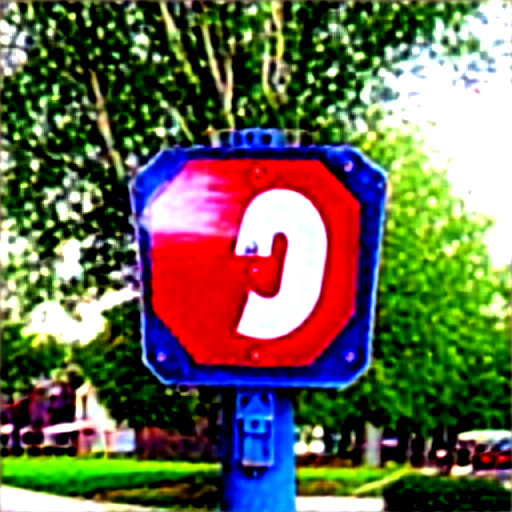

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image

In [ ]:
# image.save(f"./scrf/{prompt[0],num_inference_steps,seed, guidance_scale}.jpg")
image.save(f"./testing.jpg")

In [ ]:
prompt[0]

'stopo sign'

In [ ]:
len(scheduler),scheduler.timesteps

(1000, tensor([999, 832, 666, 500, 333, 166]))

In [ ]:
scheduler.set_timesteps(num_inference_steps)

In [ ]:
scheduler.timesteps

tensor([999, 832, 666, 500, 333, 166])

In [ ]:
len(scheduler)

1000

In [ ]:
image

tensor([[[[-2.0833e-02, -2.2054e-02, -9.1660e-04,  ...,  5.8820e-01,
            5.2229e-01,  3.9669e-01],
          [-4.6445e-02, -2.0013e-02,  1.5311e-02,  ...,  8.0748e-01,
            7.2753e-01,  5.3661e-01],
          [-9.8314e-02, -8.2375e-02, -5.9207e-02,  ...,  8.7193e-01,
            8.0410e-01,  6.0624e-01],
          ...,
          [ 6.1792e-01,  8.7231e-01,  9.8826e-01,  ..., -1.0324e+00,
           -7.9140e-01, -4.9137e-01],
          [ 5.4057e-01,  7.9255e-01,  8.7243e-01,  ..., -8.1857e-01,
           -6.6751e-01, -4.1178e-01],
          [ 4.3962e-01,  6.3182e-01,  7.0414e-01,  ..., -5.4061e-01,
           -4.3936e-01, -2.6211e-01]],

         [[-9.0645e-02, -1.0954e-01, -1.0292e-01,  ...,  6.3761e-01,
            5.5389e-01,  4.3259e-01],
          [-1.2718e-01, -1.4565e-01, -1.1949e-01,  ...,  8.2859e-01,
            6.8057e-01,  5.4705e-01],
          [-1.9322e-01, -2.4166e-01, -1.8959e-01,  ...,  9.5335e-01,
            7.8677e-01,  6.3225e-01],
          ...,
     